<a href="https://colab.research.google.com/github/rahulkumar1502/ERA-V2/blob/main/ERA_V2_S8_LN_Rahul_Kumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 42587591.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 3, 32, 32])
labels.shape: torch.Size([128])


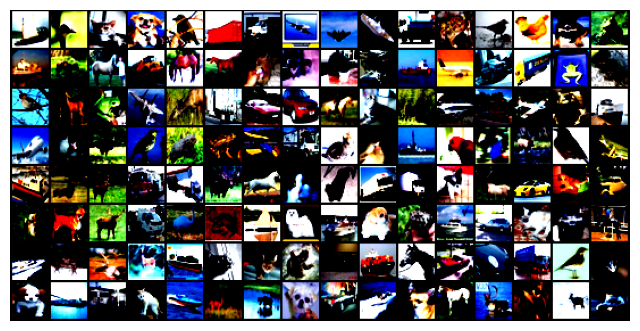

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_loader:
  print('images.shape:', images.shape)
  print('labels.shape:', labels.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
  break

In [6]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       # C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4, 16),
            nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4, 16),
            nn.Dropout(dropout_value)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4, 16),
            nn.Dropout(dropout_value)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(16, 64),
            nn.Dropout(dropout_value)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,304
             ReLU-12           [-1, 16, 16, 16]               0
        GroupNorm-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []
misclassified_pred_labels = []
misclassified_true_labels = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            try:
              misclassified_indices = ~pred.eq(target.view_as(pred)).squeeze()
              misclassified_pred_labels.extend(pred[misclassified_indices].squeeze().tolist())
              misclassified_true_labels.extend(target[misclassified_indices].tolist())
              misclassified_images.extend(data[misclassified_indices])
            except Exception as e:
              pass
              #print('error:',e,misclassified_indices,misclassified_pred_labels)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6384938955307007 Batch_id=390 Accuracy=33.79: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]



Test set: Average loss: 1.4335, Accuracy: 4695/10000 (46.95%)

EPOCH: 1


Loss=1.1273139715194702 Batch_id=390 Accuracy=51.16: 100%|██████████| 391/391 [00:18<00:00, 21.16it/s]



Test set: Average loss: 1.2495, Accuracy: 5441/10000 (54.41%)

EPOCH: 2


Loss=0.9335852861404419 Batch_id=390 Accuracy=57.76: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]



Test set: Average loss: 1.1238, Accuracy: 5908/10000 (59.08%)

EPOCH: 3


Loss=0.8737151026725769 Batch_id=390 Accuracy=61.95: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]



Test set: Average loss: 1.0285, Accuracy: 6306/10000 (63.06%)

EPOCH: 4


Loss=1.1065335273742676 Batch_id=390 Accuracy=65.23: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]



Test set: Average loss: 0.9921, Accuracy: 6445/10000 (64.45%)

EPOCH: 5


Loss=0.7577540278434753 Batch_id=390 Accuracy=66.69: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s]



Test set: Average loss: 0.9248, Accuracy: 6679/10000 (66.79%)

EPOCH: 6


Loss=0.7264603972434998 Batch_id=390 Accuracy=71.00: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]



Test set: Average loss: 0.8586, Accuracy: 6929/10000 (69.29%)

EPOCH: 7


Loss=0.8173884153366089 Batch_id=390 Accuracy=71.40: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]



Test set: Average loss: 0.8536, Accuracy: 6954/10000 (69.54%)

EPOCH: 8


Loss=0.8723570704460144 Batch_id=390 Accuracy=71.72: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]



Test set: Average loss: 0.8427, Accuracy: 6979/10000 (69.79%)

EPOCH: 9


Loss=0.7832444906234741 Batch_id=390 Accuracy=72.06: 100%|██████████| 391/391 [00:18<00:00, 21.25it/s]



Test set: Average loss: 0.8356, Accuracy: 7008/10000 (70.08%)

EPOCH: 10


Loss=0.9630654454231262 Batch_id=390 Accuracy=72.30: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]



Test set: Average loss: 0.8330, Accuracy: 7059/10000 (70.59%)

EPOCH: 11


Loss=0.7965543866157532 Batch_id=390 Accuracy=72.55: 100%|██████████| 391/391 [00:18<00:00, 21.65it/s]



Test set: Average loss: 0.8292, Accuracy: 7056/10000 (70.56%)

EPOCH: 12


Loss=0.8979536890983582 Batch_id=390 Accuracy=72.99: 100%|██████████| 391/391 [00:17<00:00, 22.31it/s]



Test set: Average loss: 0.8192, Accuracy: 7084/10000 (70.84%)

EPOCH: 13


Loss=0.7910090088844299 Batch_id=390 Accuracy=73.08: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]



Test set: Average loss: 0.8192, Accuracy: 7083/10000 (70.83%)

EPOCH: 14


Loss=0.5820764303207397 Batch_id=390 Accuracy=73.21: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]



Test set: Average loss: 0.8192, Accuracy: 7075/10000 (70.75%)

EPOCH: 15


Loss=0.9068306088447571 Batch_id=390 Accuracy=73.17: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s]



Test set: Average loss: 0.8173, Accuracy: 7090/10000 (70.90%)

EPOCH: 16


Loss=0.7901168465614319 Batch_id=390 Accuracy=73.19: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]



Test set: Average loss: 0.8214, Accuracy: 7088/10000 (70.88%)

EPOCH: 17


Loss=0.7606717348098755 Batch_id=390 Accuracy=73.27: 100%|██████████| 391/391 [00:18<00:00, 21.08it/s]



Test set: Average loss: 0.8180, Accuracy: 7097/10000 (70.97%)

EPOCH: 18


Loss=1.011689305305481 Batch_id=390 Accuracy=73.16: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]



Test set: Average loss: 0.8172, Accuracy: 7091/10000 (70.91%)

EPOCH: 19


Loss=0.9351930618286133 Batch_id=390 Accuracy=73.30: 100%|██████████| 391/391 [00:18<00:00, 21.23it/s]



Test set: Average loss: 0.8173, Accuracy: 7091/10000 (70.91%)



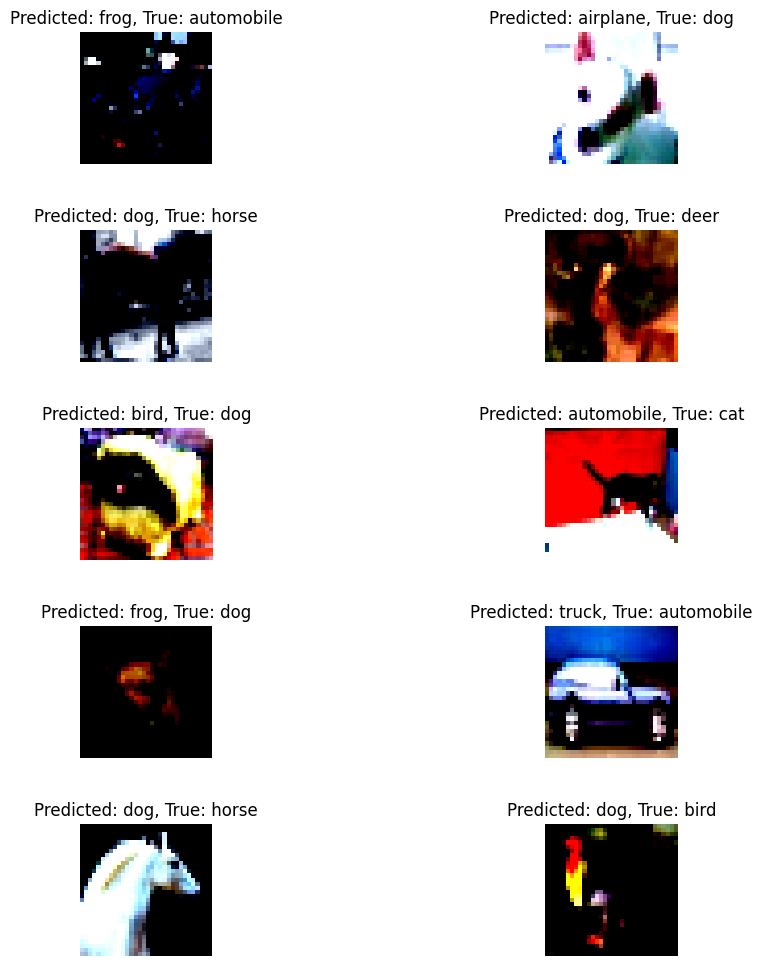

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_misclassified_images(images, pred_labels, true_labels):
    fig, axs = plt.subplots(5, 2, figsize=(10, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    axs = axs.ravel()

    for i in range(len(images)):
        pred_class_name = class_names[pred_labels[i]]
        true_class_name = class_names[true_labels[i]]

        axs[i].imshow(images[i].permute(1, 2, 0).cpu().clamp(0,1))
        axs[i].set_title(f'Predicted: {pred_class_name}, True: {true_class_name}')
        axs[i].axis('off')

    plt.show()

visualize_misclassified_images(misclassified_images[:10], misclassified_pred_labels[:10], misclassified_true_labels[:10])

In [11]:
train_losses_tensor = torch.tensor(train_losses).cuda()
train_losses_tensor = train_losses_tensor.cpu().numpy()

train_acc_tensor = torch.tensor(train_acc).cuda()
train_acc_tensor = train_acc_tensor.cpu().numpy()

test_losses_tensor = torch.tensor(test_losses).cuda()
test_losses_tensor = test_losses_tensor.cpu().numpy()

test_acc_tensor = torch.tensor(test_acc).cuda()
test_acc_tensor = test_acc_tensor.cpu().numpy()

Text(0.5, 1.0, 'Test Accuracy')

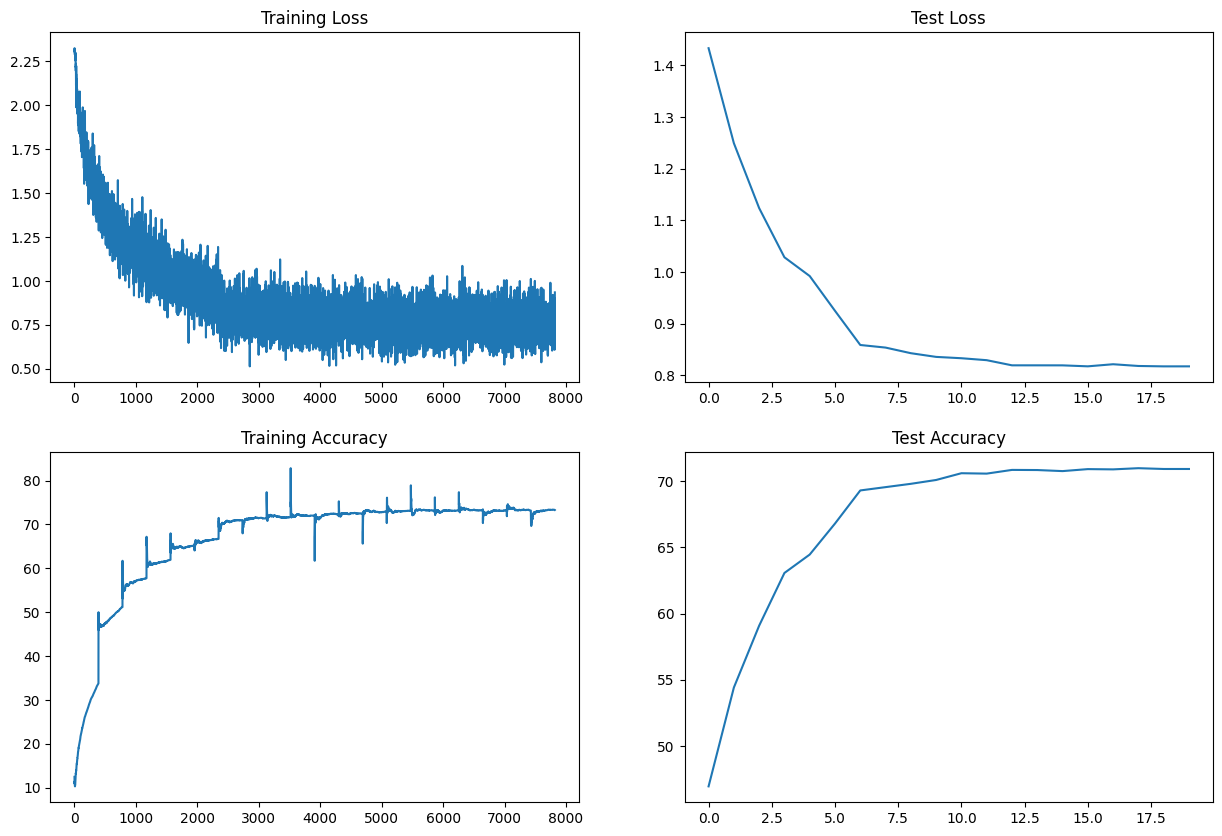

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_tensor)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_tensor)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_tensor)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_tensor)
axs[1, 1].set_title("Test Accuracy")